<a href="https://colab.research.google.com/github/FranciscoMedellin/Curso-REST-APIs-with-Flask-and-Python/blob/main/MNA_IAyAA_semana_7_Actividad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Inteligencia Artificial y Aprendizaje Automático**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## **Adtividad de la Semana 7**
###**Red Neuronal Artificial - Perceptrón Multicapa : Multilayer Perceptrón (MLP)**


**Nombres y matrículas de los integrantes del equipo:**

* Manuel Gustavo Urgell Cruz - A01368661
* Nathalia Milena Prada - A01793999
* Nancy Gabriela Gonzalez Castillo - A01794546
* Francisco Medellin Zertuche - A01794044 


Esta Tarea se deberá resolver en equipos, de acuerdo a como fueron integrados al inicio del curso.<br>
El artículo del 2016 de Moro, Rita & Vala relacionado al presente problema lo encuentras aquí:<br>
https://www.semanticscholar.org/paper/Predicting-social-media-performance-metrics-and-of-MoroRita/dec55692590820754b53c916e29bb2b42c0e5104 <br>
Y el conjunto de datos utilizado es el de la siguiente liga de la UCI:<br>
https://archive.ics.uci.edu/ml/datasets/Facebook+metrics<br>
El archivo se llama dataset_Facebook.csv y contiene 500 registros y 19 columnas.<br>

El objetivo es determinar el impacto generado por un anuncio de una marca de cosméticos en
Facebook, en el cual se intentaron varias variantes en la manera de mostrar el anuncio. Siguiendo el artículo, deberás considerar como predictores o variables de entrada aquellas que se indican en la Tabla 3 Por otro lado, en la Tabla 2, los autores consideran varios casos para la variable de salida, intentando determinar cuál puede ser el mejor caso para medir el éxito de la campaña. 


En cada sección deberás incluir todas las líneas de código necesarias para responder a cada uno de los ejercicios.

In [2]:
# Incluye aquí todos módulos, librerías y paquetes que requieras.
import pandas as pd
import numpy as np

from io import BytesIO
from urllib.request import urlopen
from warnings import filterwarnings
from zipfile import ZipFile

from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    cross_validate,
    learning_curve,
    train_test_split,
    validation_curve
)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier 

import matplotlib.pyplot as plt
import seaborn as sns


#**Ejercicio-1.** 

Considera únicamente la siguiente variable de salida que se concluye que es una de las
mejores en el artículo antes citado: ‘Lifetime People who have liked a Page and engaged with a
post'. Renombra dicha variable como “LPE” . Como variables de entrada selecciona las 7 variables
que indican los autores en la Tabla 3 del artículo citado.

In [3]:
# importar data set
response = urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip")
with ZipFile(BytesIO(response.read())) as z:
  with z.open("dataset_Facebook.csv") as f:
    df = pd.read_csv(f, delimiter=";")

# renombrar columna 14 como LPE
df.rename(columns={"Lifetime People who have liked your Page and engaged with your post":"LPE"}, inplace = True)

In [4]:
# Inputs 
c = ['Category','Page total likes','Type','Post Month', 'Post Hour','Post Weekday','Paid']
X = df.loc[: , c]

# Outputs
y = df["LPE"]

#**Ejercicio-2.**

Realiza una partición de los datos con 100 datos de Prueba y el resto para entrenamiento y
validación. 


In [5]:
# Como usaremos Cross Validation nombramos solo las inputs como Train
# 500 registros en total - 80% Traing y 20% Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100)

In [6]:
X_train.columns

Index(['Category', 'Page total likes', 'Type', 'Post Month', 'Post Hour',
       'Post Weekday', 'Paid'],
      dtype='object')

#**Ejercicio-3.**

Definirás tus propias funciones de errores para este problema de regresión. Los errores que
utilizarás son la raíz cuadrada del error cuadrático medio RMSE, el error absoluto medio MAE y el error porcentual absoluto medio MAPE. 


In [7]:
def mi_RMSE(y , yhat):
  sse = sum(np.square(y-yhat))
  mse = sse/len(y) 
  return np.sqrt(mse)

def mi_MAE(y,yhat):
  return sum(np.absolute(y-yhat))/len(y)

def mi_MAPE(y,yhat):
  return sum(np.absolute((y-yhat)/y))*100/len(y)

#**Ejercicio-4.**

Análisis de tus datos y lleva a cabo las transformaciones que consideres adecuadas tanto en los datos de entrada, como en las de salida. Utiliza un Pipeline para evitar el filtrado de información. 

In [8]:
# Analisis de datos
print("X Info: \n")
X.info()
print("Y Info: \n")
y.info()

X Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          500 non-null    int64  
 1   Page total likes  500 non-null    int64  
 2   Type              500 non-null    object 
 3   Post Month        500 non-null    int64  
 4   Post Hour         500 non-null    int64  
 5   Post Weekday      500 non-null    int64  
 6   Paid              499 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 27.5+ KB
Y Info: 

<class 'pandas.core.series.Series'>
RangeIndex: 500 entries, 0 to 499
Series name: LPE
Non-Null Count  Dtype
--------------  -----
500 non-null    int64
dtypes: int64(1)
memory usage: 4.0 KB


Todas las variables de los datos de entrada son de tipo entero y flotante. Necesitamos identificar si tenemos categoricas u ordinales en las de tipo int, mismo caso para la variable de salida.

In [9]:
# Analisis con las variables de entrada
for c in X.columns:
  unique_v = set(X[c].values)
  print(f"Valores unicos de variable " + c + ": " + str(unique_v))

Valores unicos de variable Category: {1, 2, 3}
Valores unicos de variable Page total likes: {91651, 117764, 111620, 124940, 135700, 92186, 135195, 136736, 135713, 128032, 131630, 133679, 92721, 129600, 93256, 91223, 138329, 85093, 109670, 132201, 127082, 91758, 138353, 92293, 104070, 138895, 131728, 92828, 137893, 123047, 115368, 125612, 138414, 139441, 93363, 115893, 126141, 91330, 121540, 136393, 132817, 116435, 91865, 138458, 134879, 131808, 102112, 131300, 130791, 92400, 120050, 135428, 92935, 93470, 91437, 137020, 91972, 133451, 136013, 92507, 137059, 93042, 131956, 116091, 100732, 86909, 91009, 107907, 113028, 126345, 93577, 98195, 91544, 119198, 92079, 106928, 135617, 136642, 92614, 138185, 126424, 137177, 133594, 86491, 85979, 93149, 81370, 91116, 96749, 93684}
Valores unicos de variable Type: {'Photo', 'Link', 'Status', 'Video'}
Valores unicos de variable Post Month: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Valores unicos de variable Post Hour: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1

Podemos observar las siguientes deducciones:
- Variables numericas:
  - Page total likes
- Variables categoricas:
  - Category, ya esta trasnformada{action, product, inspiration} - {1, 2, 3}.
  - Type: Necesita una transformacion ya que es del tipo object, se realizara mediante el metodo one hot encoder.
  - Paid , la variable se presenta del tipo float entonces necesita ser procesada a tipo bool o int.
- Ordinales:
  - Post Month
  - Post Weekday
  - Hour

In [10]:
categorical_variables = ["Category","Type"]
ordinal_variables = ["Post Month", "Post Weekday", "Post Hour"]
numerical_variables = ["Page total likes"]
binary_variables = ["Paid"]

**Analisis de variable numerica**

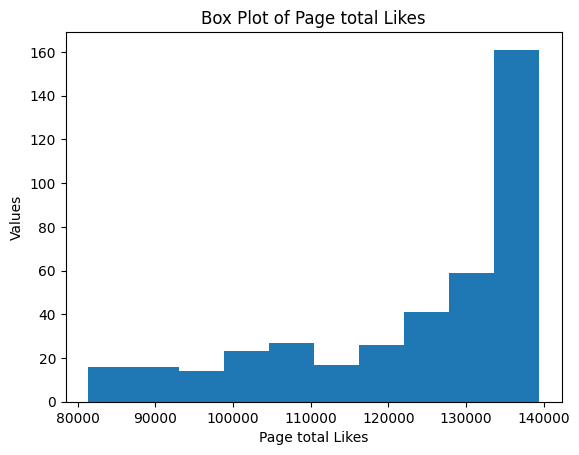

In [11]:
fig, ax = plt.subplots()
ax.hist(X_train['Page total likes'].values, bins='auto')
ax.set_xlabel("Page total Likes")
ax.set_ylabel('Values')
ax.set_title('Box Plot of {}'.format("Page total Likes"))
plt.show()

In [12]:
X_train['Page total likes'].describe()

count       400.000000
mean     123491.362500
std       16114.245296
min       81370.000000
25%      111620.000000
50%      130791.000000
75%      136642.000000
max      139441.000000
Name: Page total likes, dtype: float64

In [13]:
# cantidad de valores nulos
X_train['Page total likes'].isnull().sum()

0


Podemos observar que no existen valores nulos por lo que una imputacion no es necesaria.Para el escalamiento se usara Standard Scaler.

**Variables Categoricas**<br>
La mayoria de las variables no presentan valroes nulos a excepcion de la variable Paid. Al ser una variable de tipo binaria se recomienda una imputacion por moda para la preservacion de la variabilidad de la data.<br>
Dicha variable necesita ser trasnformada al tipo bool o int, esto para evitar que un valor flotante sea procesado por one hot encoder necesitamos primero imputar por media para que pueda ser procesado correctamente.

In [14]:
def cambiar_tipo(columna):
    return columna.astype(int)

In [15]:
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder())
])
ordinal_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])
numerical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
binary_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    #("cambio_tipo", FunctionTransformer(cambiar_tipo), ['Paid']),
    ("onehot", OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ("categorical", categorical_transformer, categorical_variables),
    ("ordinal", ordinal_transformer, ordinal_variables),
    ("numerical", numerical_transformer, numerical_variables),
    ("binary", binary_transformer, binary_variables)
])

preprocessor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OneHotEncoder())]),
                                 ['Category', 'Type']),
                                ('ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['Post Month', 'Post Weekday', 'Post Hour']),
                                ('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Page total likes']),
                                ('binary',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OneHotEncoder())]),
                                 ['Paid'])])

Variable de Salida: <br>
Ya que estamos prediciendo el numero de likes que tendra un post este es un valor numerico.

In [ ]:
y.values.sum()

304993

#**Ejercicio-5.**

Utiliza la función Dummy para modelos de regresión de scikit-learn con el conjunto que tienes de
datos de entrenamiento y validación. Para ello particiónalos en 100 para validación y 300 para
entrenamiento. Encuentra los errores RMSE, MAE y MAPE para los conjuntos de entrenamiento y
validación. Estos serán tus errores máximos que deberás tomar como referencia en el resto de la
actividad. Consulta su documentación correspondiente:
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html 


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=100, train_size=300)

#**Ejercicio-6.**

In [ ]:
None

#**Ejercicio-7.**

In [ ]:
None

#**Ejercicio-8.**

In [ ]:
None

#**Ejercicio-9.**

In [ ]:
None

#**Ejercicio-10.**

In [ ]:
None

#**Ejercicio-11.**

In [ ]:
None

#**Ejercicio-12.**

In [ ]:
None

###**Fin de la Actividad de la semana 7.**